Epoch 0, Loss: 1.0983
Epoch 100, Loss: 1.0516
Epoch 200, Loss: 1.0262
Epoch 300, Loss: 1.0114
Epoch 400, Loss: 1.0021
Epoch 500, Loss: 0.9954
Epoch 600, Loss: 0.9897
Epoch 700, Loss: 0.9839
Epoch 800, Loss: 0.9768
Epoch 900, Loss: 0.9676
Test Accuracy: 0.4406


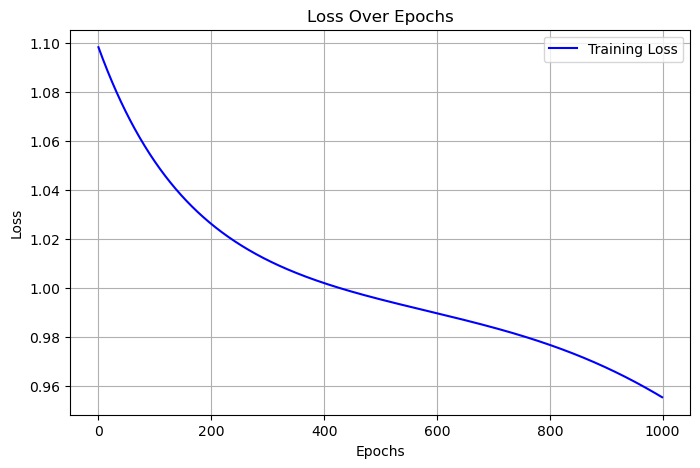

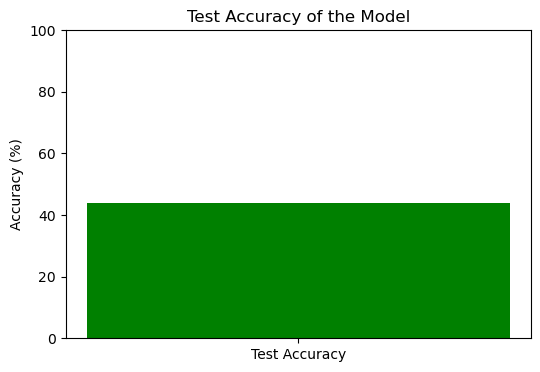

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, delimiter=";")

# Define input (X) and output (y)
X = data.iloc[:, :-1].values  # Features (all except last column)
y = data.iloc[:, -1].values   # Target (wine quality score)

# Convert target to classification (quality 3-9 -> categories)
y = np.where(y <= 5, 0, np.where(y == 6, 1, 2))

# One-hot encode target variable
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))  # Convert to one-hot encoding

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define network architecture
input_size = X_train.shape[1]  # Number of features
hidden_size = 16  # Hidden layer neurons
output_size = y.shape[1]  # Number of classes

# Initialize weights and biases
np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

# Activation functions
def relu(Z):
    """Implement the ReLU activation function."""
    return np.maximum(0, Z)

def softmax(Z):
    """Implement the softmax activation function."""
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Prevent overflow
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

# Forward propagation
def forward_propagation(X):
    """Compute the forward pass of the network."""
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# Compute loss (categorical cross-entropy)
def compute_loss(y_true, y_pred):
    """Compute the categorical cross-entropy loss."""
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m  # Adding epsilon to avoid log(0)
    return loss

# Backpropagation
def backward_propagation(X, y, Z1, A1, A2):
    """Compute the backward pass of the network."""
    m = X.shape[0]
    
    dZ2 = A2 - y  # Gradient of softmax
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * (Z1 > 0)  # ReLU derivative
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2

# Training loop
epochs = 1000
learning_rate = 0.01
losses = []  # Store loss values

for epoch in range(epochs):
    # Perform forward propagation
    Z1, A1, Z2, A2 = forward_propagation(X_train)

    # Compute loss
    loss = compute_loss(y_train, A2)
    losses.append(loss)  # Store loss

    # Perform backward propagation
    dW1, db1, dW2, db2 = backward_propagation(X_train, y_train, Z1, A1, A2)

    # Update parameters 
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Evaluate on test set
_, _, _, A2_test = forward_propagation(X_test)
y_pred = np.argmax(A2_test, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot Loss Over Epochs
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), losses, linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(6, 4))
plt.bar(["Test Accuracy"], [accuracy * 100], color='green')
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy of the Model")
plt.ylim(0, 100)
plt.show()
